In [116]:
import pandas as pd
import sys
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from src.utils import load_data, clean_dataset, process_budget_revenue, feature_engineering_pipeline




sys.path.append(os.path.abspath(os.path.join('..')))
from src.utils import load_data, clean_dataset, process_budget_revenue, feature_engineering_pipeline

raw_data_path = '../data/original/TMDB_movie_dataset.csv' 
df = load_data(raw_data_path)

print(f"rows: {df.shape[0]}")

df = clean_dataset(df)

df = process_budget_revenue(df)

df = feature_engineering_pipeline(df)
к
df = df.drop(columns='keywords')

df = df[df['budget'] > 0]

df = df[df['revenue'] > 0]

print(f"rows after filtering: {df.shape[0]}")

output_path = '../data/cleaned/TMDB_movie_dataset_cleaned.csv'
df.to_csv(output_path, index=False)

df.head(3)



rows: 1331729
rows after filtering: 5516


,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,...,popularity,genres,production_companies,production_countries,spoken_languages,companies_count,keywords_count,release_year,release_month,release_day_of_week
0,27205,Inception,8.364,34495,Released,2010-07-15,8.255328e+08,148,False,160000000.0,...,83.952,"[Action, Science Fiction, Adventure]","[Legendary Pictures, Syncopy, Warner Bros. Pic...","[United Kingdom, United States of America]","[English, French, Japanese, Swahili]",3,20,2010,7,3
1,157336,Interstellar,8.417,32571,Released,2014-11-05,7.017292e+08,169,False,165000000.0,...,140.241,"[Adventure, Drama, Science Fiction]","[Legendary Pictures, Syncopy, Lynda Obst Produ...","[United Kingdom, United States of America]",[English],3,32,2014,11,2
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1.004558e+09,152,False,185000000.0,...,130.643,"[Drama, Action, Crime, Thriller]","[DC Comics, Legendary Pictures, Syncopy, Isobe...","[United Kingdom, United States of America]","[English, Mandarin]",5,18,2008,7,2


Each movie contains a list of genres (e.g., Action, Drama, Comedy).
We convert the multi-label genre field into separate binary features.
A movie may belong to multiple genres → simple label encoding is not possible.

Multi-hot encoding captures all genres independently.

Genre is one of the strongest predictors of popularity, audience engagement, and revenue.
Examples of generated features:
genreAction
genreDrama

In [117]:
all_genres = df['genres'].explode().dropna().unique()

for g in all_genres:
    col_name = 'genre' + g.replace(' ', '')  
    df[col_name] = df['genres'].apply(lambda lst: int(g in lst))

Movie budgets range widely (from thousands to hundreds of millions).
To normalize this variable, we segment budgets into Low, Mid, and High using quantiles.

In [118]:
q = df['budget'].quantile([0, 1/3, 2/3, 1]).values

df['budget_level'] = pd.cut(
    df['budget'],
    bins=q,
    labels=['low', 'mid', 'high'],
    include_lowest=True
)


We then map categories to ordered numerical values:

In [119]:
ord_map = {'low': 0, 'mid': 1, 'high': 2}
df['budget_level_ord'] = df['budget_level'].map(ord_map)

We select Top-10 production studios by frequency and create binary flags.

In [120]:
top_n_studios = 10
top_studios = (
    df['production_companies']
        .explode()
        .value_counts()
        .head(top_n_studios)
        .index
)

top_studio_cols = []

for s in top_studios:
    col_name = 'prod_company' + ''.join(s.split())
    df[col_name] = df['production_companies'].apply(lambda lst: int(s in lst))
    top_studio_cols.append(col_name)

df['has_top_studio'] = df[top_studio_cols].max(axis=1).astype('int8')


Using the release month, we derive the season in which the movie was released.

In [121]:
def month_to_season(m):
    if m in [12, 1, 2]: return 'winter'
    elif m in [3, 4, 5]: return 'spring'
    elif m in [6, 7, 8]: return 'summer'
    else: return 'autumn'

df['season'] = df['release_month'].apply(month_to_season)
df = pd.get_dummies(df, columns=['season'], prefix='season', dtype=int)


Movies released on weekends typically perform better at the box office

In [122]:
df['is_weekend_release'] = df['release_day_of_week'].isin([4, 5, 6]).astype('int8')


Movies may contain multiple spoken languages.
We create binary features for the Top-10 most frequently used languages.

In [123]:
top_n_langs = 5

top_langs = (
    df['spoken_languages']
        .explode()
        .dropna()
        .value_counts()
        .head(top_n_langs)
        .index
)

lang_cols = []

for lang in top_langs:
    col_name = 'lang_' + lang.lower().replace(' ', '_')
    df[col_name] = df['spoken_languages'].apply(lambda lst: int(lang in lst))
    lang_cols.append(col_name)


In [124]:
cols_to_drop = ['release_date']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

df.head(3)
output_path = '../data/cleaned/TMDB_movie_dataset_working.csv'
df.to_csv(output_path, index=False)

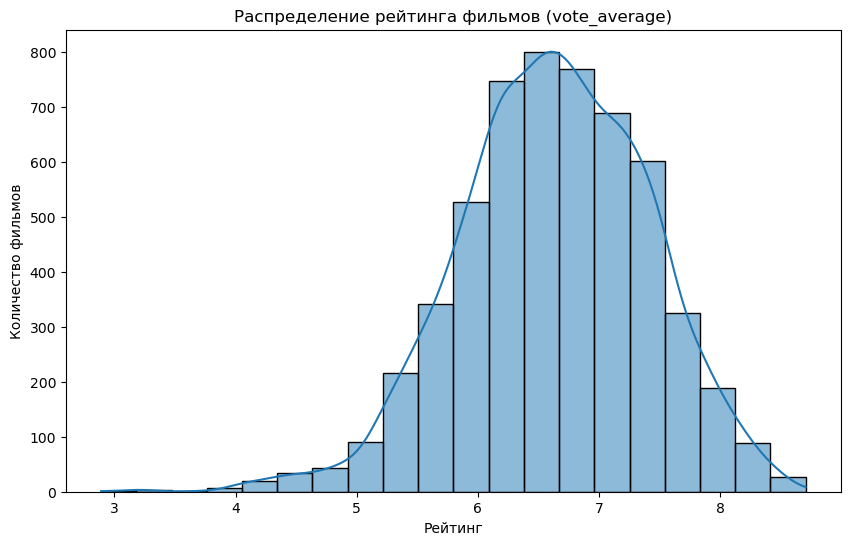

In [125]:
plt.figure(figsize=(10,6))
sns.histplot(df['vote_average'], bins=20, kde=True)
plt.title('Распределение рейтинга фильмов (vote_average)')
plt.xlabel('Рейтинг')
plt.ylabel('Количество фильмов')
plt.show()

In [126]:
cols = ['vote_average', 'budget', 'revenue', 'runtime', 'vote_count', 'popularity']
corr_matrix = df[cols].corr()
print(corr_matrix['vote_average'].sort_values(ascending=False))


vote_average    1.000000
runtime         0.379487
vote_count      0.369234
revenue         0.171252
popularity      0.109089
budget         -0.017568
Name: vote_average, dtype: float64


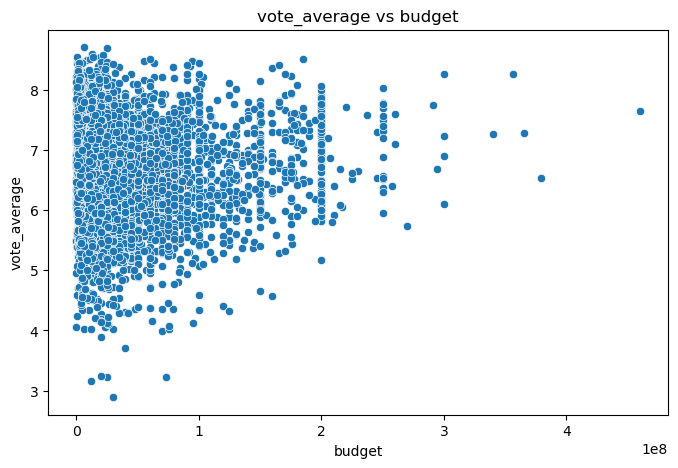

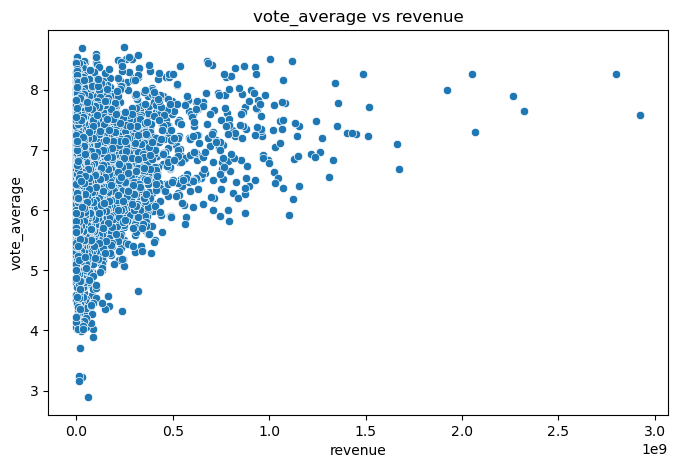

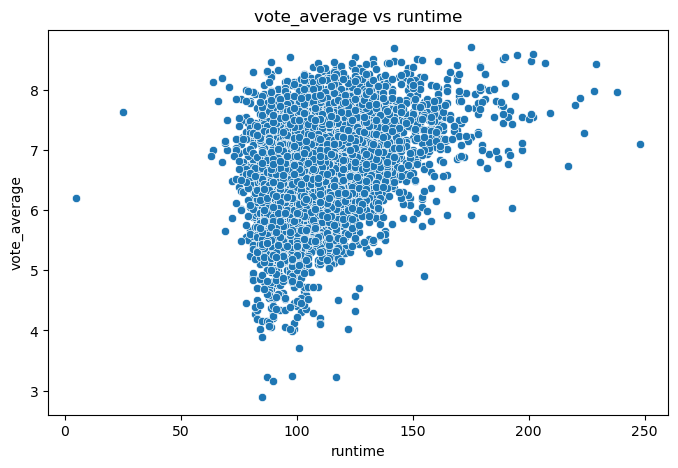

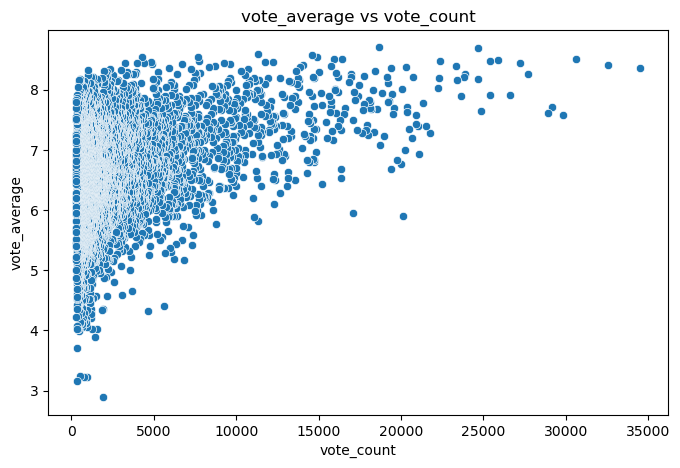

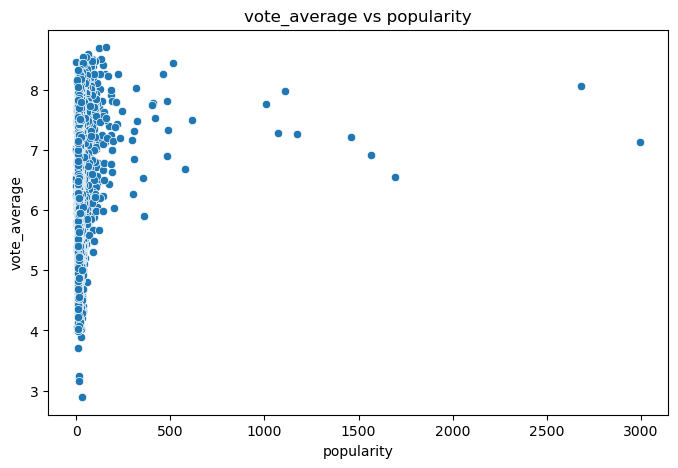

In [127]:
cols = ['budget', 'revenue', 'runtime', 'vote_count', 'popularity'] 

for col in cols:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=col, y='vote_average', data=df)
    plt.title(f'vote_average vs {col}')
    plt.xlabel(col)
    plt.ylabel('vote_average')
    plt.show()

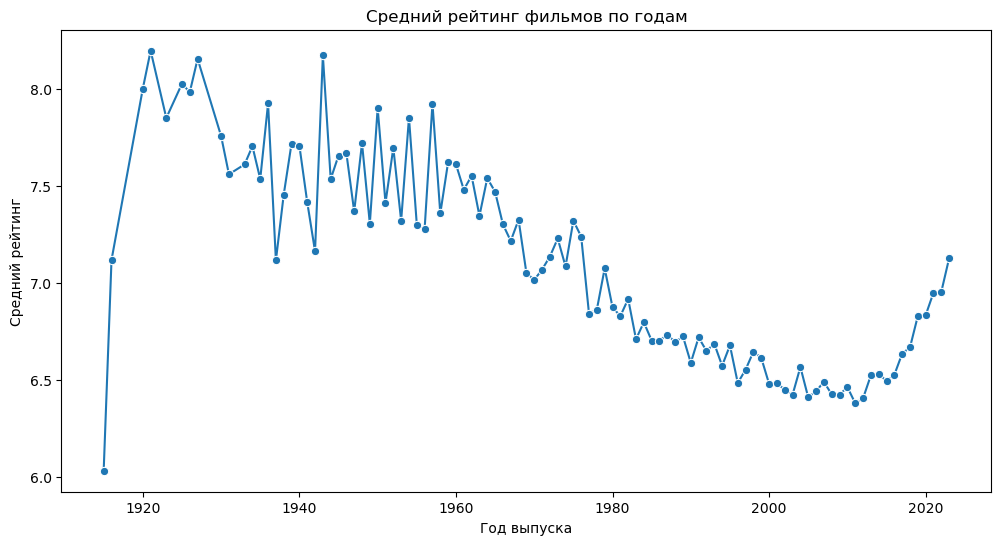

In [128]:
year_avg = df.groupby('release_year')['vote_average'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x='release_year', y='vote_average', data=year_avg, marker='o')
plt.title('Средний рейтинг фильмов по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Средний рейтинг')
plt.show()


In [129]:
df_genres = df[['vote_average', 'genres']].dropna()

df_genres = df_genres.explode('genres')

genre_avg = df_genres.groupby('genres')['vote_average'].mean().sort_values(ascending=False)

print(genre_avg)


genres
Documentary        7.172480
TV Movie           7.143000
War                7.124878
History            7.099320
Drama              6.916693
Animation          6.909676
Western            6.898615
Music              6.862320
Romance            6.705624
Crime              6.667459
Family             6.605445
Adventure          6.579887
Fantasy            6.571932
Mystery            6.542634
Thriller           6.467787
Comedy             6.467477
Action             6.462088
Science Fiction    6.433370
Horror             6.201407
Name: vote_average, dtype: float64


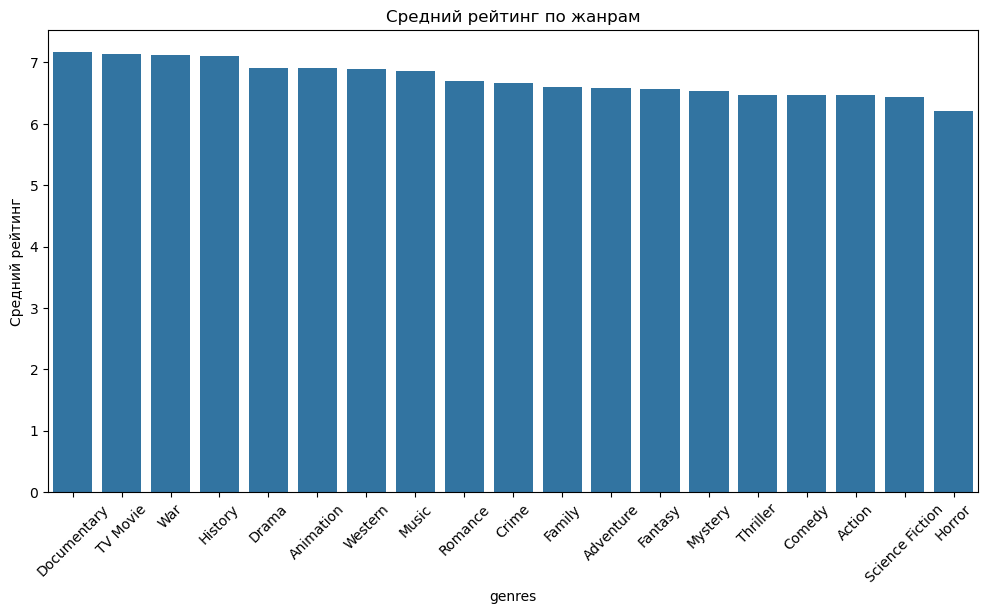

In [130]:
plt.figure(figsize=(12,6))
sns.barplot(x=genre_avg.index, y=genre_avg.values)
plt.xticks(rotation=45)
plt.title('Средний рейтинг по жанрам')
plt.ylabel('Средний рейтинг')
plt.show()


In [131]:
#Неадекватный runtime
runtime_z = np.abs(stats.zscore(df['runtime'].dropna()))
runtime_outliers_idx = df['runtime'].dropna().index[runtime_z > 4]
runtime_outliers = df.loc[runtime_outliers_idx]

print("Неадекватный runtime (слишком короткий или длинный):")
print(runtime_outliers[['title', 'runtime', 'vote_average']].sort_values('runtime'))

#Огромный бюджет и низкий рейтинг
budget_z = stats.zscore(df['budget'].fillna(0)) 
vote_z = stats.zscore(df['vote_average'].fillna(df['vote_average'].mean()))

big_budget_low_rating_idx = df.index[(budget_z > 3) & (vote_z < -1.5)]
big_budget_low_rating = df.loc[big_budget_low_rating_idx]

print("\nФильмы с огромным бюджетом и провальным рейтингом:")
print(big_budget_low_rating[['title', 'budget', 'vote_average', 'revenue']].sort_values('budget', ascending=False))


Неадекватный runtime (слишком короткий или длинный):
                                                 title  runtime  vote_average
7372                                           Tin Toy        5         6.200
4641                          Mickey's Christmas Carol       25         7.635
4857                                        Wyatt Earp      191         6.768
2775                                        Grindhouse      191         6.981
2066                                            Gandhi      191         7.543
8664                                             Nixon      192         6.924
282                           Avatar: The Way of Water      192         7.654
6580                             The Birth of a Nation      193         6.034
4772                                   The Right Stuff      193         7.427
17                                             Titanic      194         7.900
119                                   Schindler's List      195         8.573
6424       

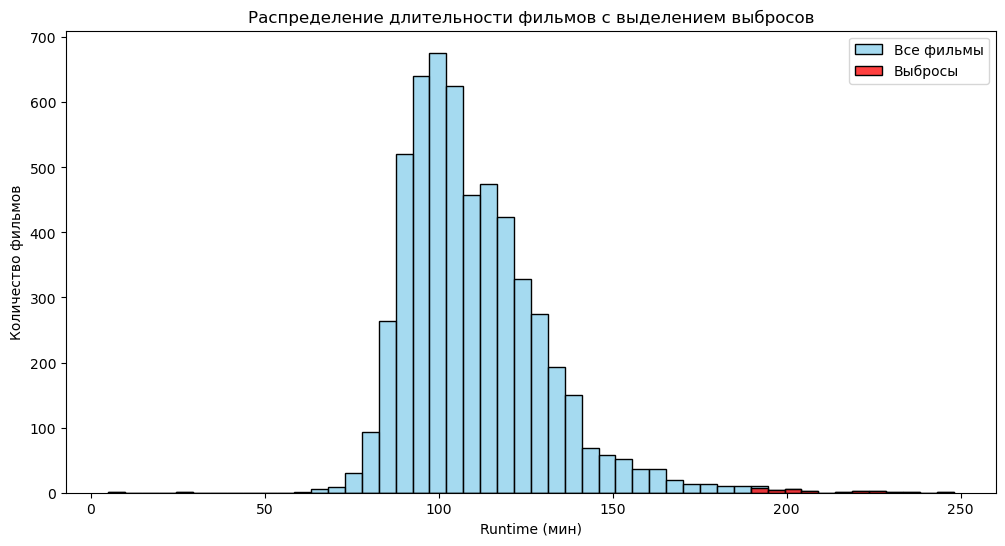

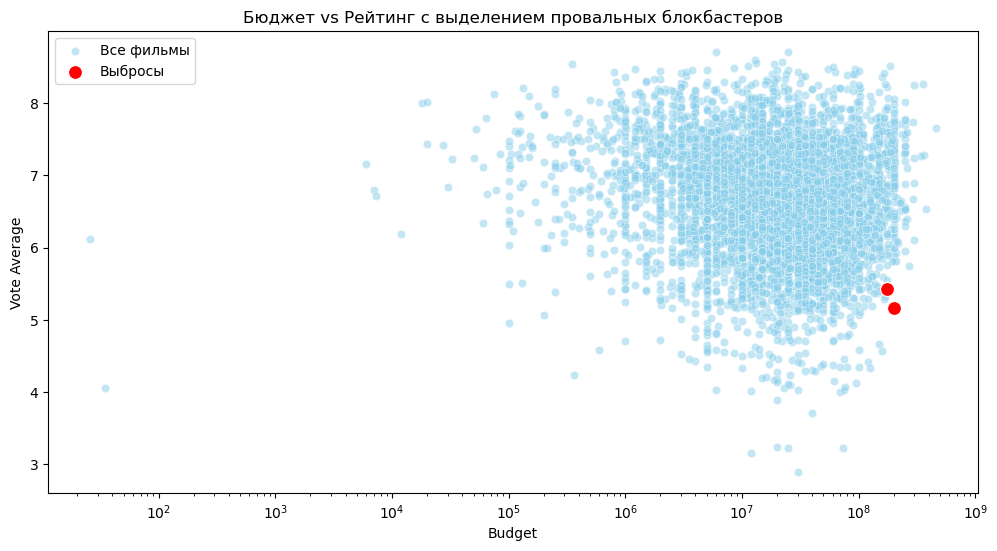

In [132]:
#Неадекватный runtime
plt.figure(figsize=(12,6))
sns.histplot(df['runtime'], bins=50, kde=False, color='skyblue', label='Все фильмы')
sns.histplot(runtime_outliers['runtime'], bins=50, kde=False, color='red', label='Выбросы')
plt.xlabel('Runtime (мин)')
plt.ylabel('Количество фильмов')
plt.title('Распределение длительности фильмов с выделением выбросов')
plt.legend()
plt.show()

#Огромный бюджет и низкий рейтинг
plt.figure(figsize=(12,6))
sns.scatterplot(x='budget', y='vote_average', data=df, color='skyblue', alpha=0.5, label='Все фильмы')
sns.scatterplot(x='budget', y='vote_average', data=big_budget_low_rating, color='red', s=100, label='Выбросы')
plt.xlabel('Budget')
plt.ylabel('Vote Average')
plt.title('Бюджет vs Рейтинг с выделением провальных блокбастеров')
plt.xscale('log') 
plt.legend()
plt.show()
